In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, glossQ, dlossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.g_lossQ, model.d_lossQ,
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs, 
                                                                       model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 gloss:0.5724 dloss:1.3698 glossQ:1.0150 dlossQ:1.8839 exploreP:0.9979
Episode:1 meanR:19.0000 R:17.0000 rate:0.0340 gloss:0.5750 dloss:1.3669 glossQ:1.0177 dlossQ:1.8480 exploreP:0.9962
Episode:2 meanR:23.6667 R:33.0000 rate:0.0660 gloss:0.5928 dloss:1.3730 glossQ:1.0148 dlossQ:1.8475 exploreP:0.9930
Episode:3 meanR:21.7500 R:16.0000 rate:0.0320 gloss:0.5961 dloss:1.3641 glossQ:1.0165 dlossQ:1.8349 exploreP:0.9914
Episode:4 meanR:23.8000 R:32.0000 rate:0.0640 gloss:0.6202 dloss:1.3591 glossQ:1.0129 dlossQ:1.7856 exploreP:0.9883
Episode:5 meanR:22.1667 R:14.0000 rate:0.0280 gloss:0.6367 dloss:1.3748 glossQ:1.0090 dlossQ:1.7879 exploreP:0.9869
Episode:6 meanR:21.0000 R:14.0000 rate:0.0280 gloss:0.6474 dloss:1.3637 glossQ:1.0054 dlossQ:1.7389 exploreP:0.9856
Episode:7 meanR:20.2500 R:15.0000 rate:0.0300 gloss:0.6335 dloss:1.3586 glossQ:1.0087 dlossQ:1.7623 exploreP:0.9841
Episode:8 meanR:24.7778 R:61.0000 rate:0.1220 gloss:0.6424 dloss:1.3653 

Episode:71 meanR:28.5694 R:29.0000 rate:0.0580 gloss:0.6622 dloss:1.3658 glossQ:1.0037 dlossQ:1.5988 exploreP:0.8159
Episode:72 meanR:29.3425 R:85.0000 rate:0.1700 gloss:0.6582 dloss:1.3679 glossQ:1.0022 dlossQ:1.5822 exploreP:0.8091
Episode:73 meanR:29.2162 R:20.0000 rate:0.0400 gloss:0.6582 dloss:1.3717 glossQ:1.0027 dlossQ:1.5726 exploreP:0.8075
Episode:74 meanR:29.2400 R:31.0000 rate:0.0620 gloss:0.6605 dloss:1.3674 glossQ:1.0077 dlossQ:1.5652 exploreP:0.8050
Episode:75 meanR:29.0263 R:13.0000 rate:0.0260 gloss:0.6684 dloss:1.3665 glossQ:1.0019 dlossQ:1.5772 exploreP:0.8040
Episode:76 meanR:29.4675 R:63.0000 rate:0.1260 gloss:0.6595 dloss:1.3668 glossQ:1.0019 dlossQ:1.5887 exploreP:0.7990
Episode:77 meanR:29.5513 R:36.0000 rate:0.0720 gloss:0.6610 dloss:1.3653 glossQ:1.0021 dlossQ:1.5868 exploreP:0.7962
Episode:78 meanR:29.3165 R:11.0000 rate:0.0220 gloss:0.6609 dloss:1.3626 glossQ:1.0062 dlossQ:1.5487 exploreP:0.7953
Episode:79 meanR:29.1625 R:17.0000 rate:0.0340 gloss:0.6586 dlos

Episode:141 meanR:53.7700 R:198.0000 rate:0.3960 gloss:0.6350 dloss:1.3662 glossQ:1.0029 dlossQ:1.5385 exploreP:0.5272
Episode:142 meanR:54.8700 R:134.0000 rate:0.2680 gloss:0.6364 dloss:1.3684 glossQ:1.0026 dlossQ:1.5210 exploreP:0.5204
Episode:143 meanR:55.4800 R:79.0000 rate:0.1580 gloss:0.6382 dloss:1.3704 glossQ:1.0029 dlossQ:1.5121 exploreP:0.5163
Episode:144 meanR:56.3500 R:113.0000 rate:0.2260 gloss:0.6382 dloss:1.3688 glossQ:1.0028 dlossQ:1.4998 exploreP:0.5106
Episode:145 meanR:57.5900 R:143.0000 rate:0.2860 gloss:0.6456 dloss:1.3721 glossQ:1.0019 dlossQ:1.4852 exploreP:0.5035
Episode:146 meanR:58.2800 R:95.0000 rate:0.1900 gloss:0.6507 dloss:1.3670 glossQ:1.0045 dlossQ:1.4848 exploreP:0.4989
Episode:147 meanR:59.3400 R:140.0000 rate:0.2800 gloss:0.6334 dloss:1.3674 glossQ:1.0022 dlossQ:1.5102 exploreP:0.4921
Episode:148 meanR:59.6000 R:58.0000 rate:0.1160 gloss:0.6310 dloss:1.3686 glossQ:1.0040 dlossQ:1.5045 exploreP:0.4893
Episode:149 meanR:59.8500 R:41.0000 rate:0.0820 glo

Episode:210 meanR:156.6300 R:147.0000 rate:0.2940 gloss:0.6556 dloss:1.3793 glossQ:1.0033 dlossQ:1.3184 exploreP:0.1510
Episode:211 meanR:158.1000 R:228.0000 rate:0.4560 gloss:0.6617 dloss:1.3806 glossQ:1.0019 dlossQ:1.3014 exploreP:0.1478
Episode:212 meanR:158.9100 R:168.0000 rate:0.3360 gloss:0.6649 dloss:1.3814 glossQ:1.0022 dlossQ:1.2893 exploreP:0.1455
Episode:213 meanR:163.1300 R:500.0000 rate:1.0000 gloss:0.6653 dloss:1.3799 glossQ:1.0022 dlossQ:1.2884 exploreP:0.1389
Episode:214 meanR:164.2000 R:190.0000 rate:0.3800 gloss:0.6682 dloss:1.3807 glossQ:1.0019 dlossQ:1.2795 exploreP:0.1365
Episode:215 meanR:169.0100 R:500.0000 rate:1.0000 gloss:0.6707 dloss:1.3814 glossQ:1.0013 dlossQ:1.2588 exploreP:0.1303
Episode:216 meanR:170.6500 R:240.0000 rate:0.4800 gloss:0.6759 dloss:1.3810 glossQ:1.0016 dlossQ:1.2352 exploreP:0.1274
Episode:217 meanR:173.0900 R:287.0000 rate:0.5740 gloss:0.6731 dloss:1.3813 glossQ:1.0019 dlossQ:1.2270 exploreP:0.1241
Episode:218 meanR:173.1000 R:192.0000 ra

Episode:279 meanR:328.9000 R:192.0000 rate:0.3840 gloss:0.7222 dloss:1.3307 glossQ:1.0151 dlossQ:0.7580 exploreP:0.0210
Episode:280 meanR:330.7100 R:500.0000 rate:1.0000 gloss:0.7162 dloss:1.3250 glossQ:1.0175 dlossQ:0.7534 exploreP:0.0204
Episode:281 meanR:331.0700 R:177.0000 rate:0.3540 gloss:0.7106 dloss:1.3216 glossQ:1.0177 dlossQ:0.7603 exploreP:0.0203
Episode:282 meanR:334.0800 R:500.0000 rate:1.0000 gloss:0.7069 dloss:1.3108 glossQ:1.0179 dlossQ:0.7390 exploreP:0.0198
Episode:283 meanR:336.1000 R:500.0000 rate:1.0000 gloss:0.7117 dloss:1.3098 glossQ:1.0195 dlossQ:0.7034 exploreP:0.0193
Episode:284 meanR:339.4000 R:495.0000 rate:0.9900 gloss:0.7244 dloss:1.3068 glossQ:1.0169 dlossQ:0.6970 exploreP:0.0188
Episode:285 meanR:342.0400 R:500.0000 rate:1.0000 gloss:0.7194 dloss:1.2962 glossQ:1.0188 dlossQ:0.6799 exploreP:0.0184
Episode:286 meanR:342.7800 R:197.0000 rate:0.3940 gloss:0.7277 dloss:1.3138 glossQ:1.0174 dlossQ:0.6808 exploreP:0.0182
Episode:287 meanR:341.4400 R:154.0000 ra

Episode:348 meanR:445.8700 R:500.0000 rate:1.0000 gloss:0.6563 dloss:1.0793 glossQ:1.1444 dlossQ:0.3805 exploreP:0.0105
Episode:349 meanR:444.6400 R:360.0000 rate:0.7200 gloss:0.6524 dloss:1.0624 glossQ:1.1490 dlossQ:0.3613 exploreP:0.0105
Episode:350 meanR:446.6400 R:500.0000 rate:1.0000 gloss:0.6776 dloss:1.0740 glossQ:1.1579 dlossQ:0.4057 exploreP:0.0105
Episode:351 meanR:446.6400 R:500.0000 rate:1.0000 gloss:0.6333 dloss:1.0684 glossQ:1.1639 dlossQ:0.3660 exploreP:0.0105
Episode:352 meanR:446.6400 R:500.0000 rate:1.0000 gloss:0.6733 dloss:1.0950 glossQ:1.1593 dlossQ:0.4401 exploreP:0.0104
Episode:353 meanR:447.0400 R:500.0000 rate:1.0000 gloss:0.6647 dloss:1.0891 glossQ:1.1560 dlossQ:0.3961 exploreP:0.0104
Episode:354 meanR:447.0400 R:500.0000 rate:1.0000 gloss:0.6573 dloss:1.0766 glossQ:1.1631 dlossQ:0.4225 exploreP:0.0104
Episode:355 meanR:447.0400 R:500.0000 rate:1.0000 gloss:0.6502 dloss:1.0583 glossQ:1.1726 dlossQ:0.3937 exploreP:0.0104
Episode:356 meanR:447.3500 R:500.0000 ra

Episode:417 meanR:482.6200 R:500.0000 rate:1.0000 gloss:0.2218 dloss:0.9852 glossQ:3.3310 dlossQ:1.2460 exploreP:0.0100
Episode:418 meanR:482.6200 R:500.0000 rate:1.0000 gloss:0.1914 dloss:0.9983 glossQ:3.3650 dlossQ:1.1868 exploreP:0.0100
Episode:419 meanR:482.1900 R:457.0000 rate:0.9140 gloss:0.2014 dloss:0.9993 glossQ:3.3107 dlossQ:1.2408 exploreP:0.0100
Episode:420 meanR:482.1900 R:500.0000 rate:1.0000 gloss:0.1978 dloss:0.9953 glossQ:3.3783 dlossQ:1.2552 exploreP:0.0100
Episode:421 meanR:482.1900 R:500.0000 rate:1.0000 gloss:0.1772 dloss:0.9999 glossQ:3.4215 dlossQ:1.2589 exploreP:0.0100
Episode:422 meanR:483.9700 R:500.0000 rate:1.0000 gloss:0.1560 dloss:1.0054 glossQ:3.5641 dlossQ:1.3158 exploreP:0.0100
Episode:423 meanR:483.9700 R:500.0000 rate:1.0000 gloss:0.1597 dloss:1.0022 glossQ:3.5692 dlossQ:1.3086 exploreP:0.0100
Episode:424 meanR:486.1200 R:500.0000 rate:1.0000 gloss:0.1193 dloss:1.0261 glossQ:3.8186 dlossQ:1.4051 exploreP:0.0100
Episode:425 meanR:486.1200 R:500.0000 ra

Episode:485 meanR:227.0600 R:10.0000 rate:0.0200 gloss:-274.3337 dloss:1.3959 glossQ:9.3424 dlossQ:341.7137 exploreP:0.0100
Episode:486 meanR:222.1600 R:10.0000 rate:0.0200 gloss:-293.0302 dloss:1.3994 glossQ:10.1613 dlossQ:368.0477 exploreP:0.0100
Episode:487 meanR:217.2500 R:9.0000 rate:0.0180 gloss:-293.5446 dloss:1.3984 glossQ:10.0986 dlossQ:366.6777 exploreP:0.0100
Episode:488 meanR:213.4400 R:10.0000 rate:0.0200 gloss:-312.2663 dloss:1.3985 glossQ:10.2203 dlossQ:390.2580 exploreP:0.0100
Episode:489 meanR:210.4100 R:8.0000 rate:0.0160 gloss:-316.5599 dloss:1.4035 glossQ:10.6898 dlossQ:394.7152 exploreP:0.0100
Episode:490 meanR:205.5000 R:9.0000 rate:0.0180 gloss:-329.6366 dloss:1.4048 glossQ:10.9609 dlossQ:415.1535 exploreP:0.0100
Episode:491 meanR:200.5900 R:9.0000 rate:0.0180 gloss:-340.4420 dloss:1.3950 glossQ:11.3995 dlossQ:427.1223 exploreP:0.0100
Episode:492 meanR:195.6800 R:9.0000 rate:0.0180 gloss:-382.0078 dloss:1.3941 glossQ:12.5711 dlossQ:478.1051 exploreP:0.0100
Episod

Episode:551 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-1864.5308 dloss:1.3941 glossQ:56.4953 dlossQ:2336.7383 exploreP:0.0100
Episode:552 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-1861.3379 dloss:1.4000 glossQ:58.6773 dlossQ:2333.5640 exploreP:0.0100
Episode:553 meanR:9.3900 R:8.0000 rate:0.0160 gloss:-1954.0811 dloss:1.3890 glossQ:59.6620 dlossQ:2435.8589 exploreP:0.0100
Episode:554 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-1941.0820 dloss:1.3906 glossQ:61.1476 dlossQ:2418.0376 exploreP:0.0100
Episode:555 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-1906.1490 dloss:1.3305 glossQ:253.5455 dlossQ:3231.1077 exploreP:0.0100
Episode:556 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-2167.5701 dloss:1.3906 glossQ:65.3177 dlossQ:2714.8591 exploreP:0.0100
Episode:557 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-2345.6829 dloss:1.3895 glossQ:69.5022 dlossQ:2947.9976 exploreP:0.0100
Episode:558 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-2319.6885 dloss:1.3906 glossQ:68.0667 dlossQ:2917.9543 exploreP:0.0100
Ep

Episode:617 meanR:9.5500 R:9.0000 rate:0.0180 gloss:-8601.9717 dloss:1.3908 glossQ:283.2894 dlossQ:10860.3398 exploreP:0.0100
Episode:618 meanR:9.5400 R:9.0000 rate:0.0180 gloss:-8795.5430 dloss:1.3943 glossQ:292.8837 dlossQ:11123.9316 exploreP:0.0100
Episode:619 meanR:9.5500 R:11.0000 rate:0.0220 gloss:-8535.2822 dloss:1.3885 glossQ:302.1729 dlossQ:10717.2119 exploreP:0.0100
Episode:620 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-9041.4082 dloss:1.3961 glossQ:297.6974 dlossQ:11385.1514 exploreP:0.0100
Episode:621 meanR:9.5400 R:10.0000 rate:0.0200 gloss:-7849.9688 dloss:1.3982 glossQ:297.3266 dlossQ:9813.9902 exploreP:0.0100
Episode:622 meanR:9.5400 R:9.0000 rate:0.0180 gloss:-9093.1230 dloss:1.3976 glossQ:340.9623 dlossQ:11328.9434 exploreP:0.0100
Episode:623 meanR:9.5500 R:10.0000 rate:0.0200 gloss:-8997.7129 dloss:1.3884 glossQ:322.8928 dlossQ:11200.6162 exploreP:0.0100
Episode:624 meanR:9.5500 R:10.0000 rate:0.0200 gloss:-8694.9375 dloss:1.3899 glossQ:329.3159 dlossQ:10862.8291 explo

Episode:682 meanR:9.3800 R:8.0000 rate:0.0160 gloss:-23316.6895 dloss:1.3891 glossQ:962.4171 dlossQ:29315.8066 exploreP:0.0100
Episode:683 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-24626.7539 dloss:1.3943 glossQ:949.9946 dlossQ:30934.0176 exploreP:0.0100
Episode:684 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-21893.8477 dloss:1.3944 glossQ:973.0495 dlossQ:27530.1035 exploreP:0.0100
Episode:685 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-26133.1934 dloss:1.3930 glossQ:1038.5828 dlossQ:33008.8516 exploreP:0.0100
Episode:686 meanR:9.3300 R:8.0000 rate:0.0160 gloss:-25398.4316 dloss:1.3926 glossQ:1046.3047 dlossQ:32495.3926 exploreP:0.0100
Episode:687 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-24232.8926 dloss:1.3885 glossQ:1019.8172 dlossQ:30325.2559 exploreP:0.0100
Episode:688 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-26993.0059 dloss:1.3885 glossQ:1064.1637 dlossQ:33843.9805 exploreP:0.0100
Episode:689 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-28223.7734 dloss:1.3897 glossQ:1086.2822 dlossQ:3502

Episode:746 meanR:9.2300 R:9.0000 rate:0.0180 gloss:-57824.4062 dloss:1.3905 glossQ:2712.4404 dlossQ:72997.0234 exploreP:0.0100
Episode:747 meanR:9.2400 R:10.0000 rate:0.0200 gloss:-55386.1484 dloss:1.3892 glossQ:2684.7927 dlossQ:69337.8672 exploreP:0.0100
Episode:748 meanR:9.2600 R:10.0000 rate:0.0200 gloss:-55393.8438 dloss:1.3906 glossQ:2744.8728 dlossQ:69753.6406 exploreP:0.0100
Episode:749 meanR:9.2600 R:10.0000 rate:0.0200 gloss:-64401.2812 dloss:1.3957 glossQ:7218.8662 dlossQ:97173.7188 exploreP:0.0100
Episode:750 meanR:9.2500 R:9.0000 rate:0.0180 gloss:-53913.8828 dloss:1.3330 glossQ:8506.3330 dlossQ:95203.3438 exploreP:0.0100
Episode:751 meanR:9.2600 R:9.0000 rate:0.0180 gloss:-56299.7031 dloss:1.3886 glossQ:2883.4106 dlossQ:70528.5781 exploreP:0.0100
Episode:752 meanR:9.2500 R:8.0000 rate:0.0160 gloss:-60420.3164 dloss:1.3918 glossQ:2979.2251 dlossQ:75675.9297 exploreP:0.0100
Episode:753 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-51697.2227 dloss:1.3242 glossQ:8892.9854 dlossQ:

Episode:810 meanR:9.3300 R:12.0000 rate:0.0240 gloss:-110393.5078 dloss:1.3881 glossQ:6670.8374 dlossQ:138598.0469 exploreP:0.0100
Episode:811 meanR:9.3100 R:8.0000 rate:0.0160 gloss:-111339.4297 dloss:1.3921 glossQ:6326.4980 dlossQ:141761.6719 exploreP:0.0100
Episode:812 meanR:9.3000 R:8.0000 rate:0.0160 gloss:-124969.8594 dloss:1.3221 glossQ:19981.2930 dlossQ:220217.7344 exploreP:0.0100
Episode:813 meanR:9.2800 R:8.0000 rate:0.0160 gloss:-126208.7344 dloss:1.3877 glossQ:6971.0615 dlossQ:159003.2500 exploreP:0.0100
Episode:814 meanR:9.2900 R:10.0000 rate:0.0200 gloss:-125848.3750 dloss:1.3886 glossQ:6798.1382 dlossQ:160355.8281 exploreP:0.0100
Episode:815 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-124223.9141 dloss:1.3915 glossQ:6913.8975 dlossQ:159071.2188 exploreP:0.0100
Episode:816 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-123036.9297 dloss:1.3876 glossQ:6931.4810 dlossQ:154591.1875 exploreP:0.0100
Episode:817 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-127237.7344 dloss:1.3271 glossQ:2

Episode:873 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-231261.3906 dloss:1.3882 glossQ:14270.5352 dlossQ:296778.4375 exploreP:0.0100
Episode:874 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-246517.8281 dloss:1.3893 glossQ:14284.8057 dlossQ:318132.9688 exploreP:0.0100
Episode:875 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-233646.5312 dloss:1.3895 glossQ:14416.0762 dlossQ:300254.9375 exploreP:0.0100
Episode:876 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-218016.5312 dloss:1.3884 glossQ:14424.3936 dlossQ:281029.6875 exploreP:0.0100
Episode:877 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-200491.3438 dloss:1.3125 glossQ:44635.7852 dlossQ:401360.0000 exploreP:0.0100
Episode:878 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-269136.1250 dloss:1.3879 glossQ:15087.9492 dlossQ:344045.1250 exploreP:0.0100
Episode:879 meanR:9.3400 R:8.0000 rate:0.0160 gloss:-225326.9375 dloss:1.3130 glossQ:45660.6328 dlossQ:436843.4688 exploreP:0.0100
Episode:880 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-231892.7031 dloss:1.3248 glo

Episode:936 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-330423.5625 dloss:1.3291 glossQ:72544.7656 dlossQ:647340.1250 exploreP:0.0100
Episode:937 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-478852.8438 dloss:1.3899 glossQ:30186.5391 dlossQ:631361.5000 exploreP:0.0100
Episode:938 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-426041.3750 dloss:1.3967 glossQ:28758.7324 dlossQ:556238.4375 exploreP:0.0100
Episode:939 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-445459.5625 dloss:1.3897 glossQ:29046.2559 dlossQ:584651.1875 exploreP:0.0100
Episode:940 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-423581.6875 dloss:1.3886 glossQ:29837.4355 dlossQ:547266.0000 exploreP:0.0100
Episode:941 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-445408.6250 dloss:1.3922 glossQ:30043.3711 dlossQ:578158.7500 exploreP:0.0100
Episode:942 meanR:9.3000 R:9.0000 rate:0.0180 gloss:-408723.5312 dloss:1.3183 glossQ:86587.6797 dlossQ:797520.0000 exploreP:0.0100
Episode:943 meanR:9.2800 R:8.0000 rate:0.0160 gloss:-399056.4062 dloss:1.3112 glo

Episode:999 meanR:9.2100 R:8.0000 rate:0.0160 gloss:-674712.0000 dloss:1.3116 glossQ:148058.0938 dlossQ:1350066.7500 exploreP:0.0100
Episode:1000 meanR:9.1800 R:8.0000 rate:0.0160 gloss:-754242.7500 dloss:1.3901 glossQ:52067.8906 dlossQ:986137.6250 exploreP:0.0100
Episode:1001 meanR:9.1700 R:10.0000 rate:0.0200 gloss:-706630.0625 dloss:1.3266 glossQ:131098.3594 dlossQ:1302816.8750 exploreP:0.0100
Episode:1002 meanR:9.1700 R:9.0000 rate:0.0180 gloss:-786421.4375 dloss:1.3895 glossQ:53600.4844 dlossQ:1036268.6875 exploreP:0.0100
Episode:1003 meanR:9.1600 R:9.0000 rate:0.0180 gloss:-667976.5000 dloss:1.3148 glossQ:151591.6875 dlossQ:1331859.0000 exploreP:0.0100
Episode:1004 meanR:9.1700 R:11.0000 rate:0.0220 gloss:-768701.0625 dloss:1.3867 glossQ:54453.1016 dlossQ:1019319.3750 exploreP:0.0100
Episode:1005 meanR:9.1500 R:8.0000 rate:0.0160 gloss:-763700.0000 dloss:1.3896 glossQ:54883.7344 dlossQ:1004133.1250 exploreP:0.0100
Episode:1006 meanR:9.1700 R:11.0000 rate:0.0220 gloss:-829756.9375

Episode:1061 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-987815.3125 dloss:1.2438 glossQ:411049.5625 dlossQ:2786937.7500 exploreP:0.0100
Episode:1062 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-1325957.6250 dloss:1.3904 glossQ:91092.5859 dlossQ:1759010.0000 exploreP:0.0100
Episode:1063 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-1221047.3750 dloss:1.3883 glossQ:91673.7500 dlossQ:1593988.6250 exploreP:0.0100
Episode:1064 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-1311922.0000 dloss:1.3839 glossQ:108697.7344 dlossQ:1782003.7500 exploreP:0.0100
Episode:1065 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-1170637.3750 dloss:1.3181 glossQ:256088.2812 dlossQ:2279334.0000 exploreP:0.0100
Episode:1066 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-1339322.2500 dloss:1.3893 glossQ:93982.3594 dlossQ:1749851.7500 exploreP:0.0100
Episode:1067 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-938506.0000 dloss:1.3213 glossQ:242047.7188 dlossQ:1920412.0000 exploreP:0.0100
Episode:1068 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-120

Episode:1122 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-1748022.6250 dloss:1.3899 glossQ:145832.7500 dlossQ:2320247.5000 exploreP:0.0100
Episode:1123 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-1508243.2500 dloss:1.2562 glossQ:606402.3750 dlossQ:4109004.0000 exploreP:0.0100
Episode:1124 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-1828628.3750 dloss:1.3893 glossQ:147159.9375 dlossQ:2428598.0000 exploreP:0.0100
Episode:1125 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-1921548.6250 dloss:1.3881 glossQ:150906.8438 dlossQ:2509051.5000 exploreP:0.0100
Episode:1126 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-1781138.0000 dloss:1.3894 glossQ:151089.0781 dlossQ:2362432.5000 exploreP:0.0100
Episode:1127 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-1946154.0000 dloss:1.3211 glossQ:392612.7812 dlossQ:3656616.0000 exploreP:0.0100
Episode:1128 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-1945075.0000 dloss:1.3897 glossQ:151477.7969 dlossQ:2565875.2500 exploreP:0.0100
Episode:1129 meanR:9.4400 R:9.0000 rate:0.0180 glos

Episode:1183 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-2254576.7500 dloss:1.3098 glossQ:661048.3750 dlossQ:4959488.0000 exploreP:0.0100
Episode:1184 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-2217329.0000 dloss:1.3132 glossQ:643763.8125 dlossQ:4761338.5000 exploreP:0.0100
Episode:1185 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-2305930.2500 dloss:1.2577 glossQ:933562.6250 dlossQ:6230598.0000 exploreP:0.0100
Episode:1186 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-2837943.0000 dloss:1.3905 glossQ:234247.2812 dlossQ:3748983.0000 exploreP:0.0100
Episode:1187 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-2598117.0000 dloss:1.3262 glossQ:593534.2500 dlossQ:5038932.0000 exploreP:0.0100
Episode:1188 meanR:9.3800 R:8.0000 rate:0.0160 gloss:-2492144.7500 dloss:1.3889 glossQ:235008.0156 dlossQ:3281676.5000 exploreP:0.0100
Episode:1189 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-2736115.2500 dloss:1.3887 glossQ:242346.0312 dlossQ:3610636.5000 exploreP:0.0100
Episode:1190 meanR:9.3900 R:10.0000 rate:0.0200 gloss

Episode:1244 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-3376152.5000 dloss:1.3144 glossQ:965632.5625 dlossQ:7369615.5000 exploreP:0.0100
Episode:1245 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-3982578.7500 dloss:1.3902 glossQ:356136.1250 dlossQ:5310882.0000 exploreP:0.0100
Episode:1246 meanR:9.4500 R:11.0000 rate:0.0220 gloss:-3751169.0000 dloss:1.3277 glossQ:874554.7500 dlossQ:7377536.5000 exploreP:0.0100
Episode:1247 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-4362804.5000 dloss:1.3891 glossQ:360810.0000 dlossQ:5811007.5000 exploreP:0.0100
Episode:1248 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-3468652.0000 dloss:1.2524 glossQ:1508990.0000 dlossQ:9893622.0000 exploreP:0.0100
Episode:1249 meanR:9.4500 R:8.0000 rate:0.0160 gloss:-4003237.2500 dloss:1.3881 glossQ:370148.4062 dlossQ:5293751.5000 exploreP:0.0100
Episode:1250 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-4273056.0000 dloss:1.3119 glossQ:1037988.3125 dlossQ:8719115.0000 exploreP:0.0100
Episode:1251 meanR:9.4500 R:9.0000 rate:0.0180 glos

Episode:1305 meanR:9.4500 R:8.0000 rate:0.0160 gloss:-6380221.0000 dloss:1.3899 glossQ:540218.8750 dlossQ:8605072.0000 exploreP:0.0100
Episode:1306 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-4882822.5000 dloss:1.2441 glossQ:2215104.5000 dlossQ:14065769.0000 exploreP:0.0100
Episode:1307 meanR:9.4300 R:8.0000 rate:0.0160 gloss:-4961446.0000 dloss:1.3155 glossQ:1446285.7500 dlossQ:10678463.0000 exploreP:0.0100
Episode:1308 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-5855490.5000 dloss:1.3888 glossQ:547114.5625 dlossQ:7721402.5000 exploreP:0.0100
Episode:1309 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-5695311.5000 dloss:1.3904 glossQ:545009.8750 dlossQ:7688025.0000 exploreP:0.0100
Episode:1310 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-5703260.0000 dloss:1.3918 glossQ:544966.7500 dlossQ:7694690.0000 exploreP:0.0100
Episode:1311 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-5633551.0000 dloss:1.3200 glossQ:1409695.7500 dlossQ:11325425.0000 exploreP:0.0100
Episode:1312 meanR:9.4400 R:10.0000 rate:0.0200

Episode:1365 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-6846157.0000 dloss:1.2475 glossQ:3139914.5000 dlossQ:19698644.0000 exploreP:0.0100
Episode:1366 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-6184246.0000 dloss:1.1596 glossQ:4683347.5000 dlossQ:26448310.0000 exploreP:0.0100
Episode:1367 meanR:9.4200 R:8.0000 rate:0.0160 gloss:-9075192.0000 dloss:1.3897 glossQ:774008.6250 dlossQ:12240004.0000 exploreP:0.0100
Episode:1368 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-8678209.0000 dloss:1.3890 glossQ:791373.2500 dlossQ:11547708.0000 exploreP:0.0100
Episode:1369 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-8415794.0000 dloss:1.3897 glossQ:775140.6250 dlossQ:11257171.0000 exploreP:0.0100
Episode:1370 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-7572022.0000 dloss:1.3899 glossQ:776073.3750 dlossQ:10202006.0000 exploreP:0.0100
Episode:1371 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-6870766.5000 dloss:1.2567 glossQ:3113143.0000 dlossQ:19724790.0000 exploreP:0.0100
Episode:1372 meanR:9.4200 R:8.0000 rate:0.

Episode:1425 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-8996025.0000 dloss:1.2391 glossQ:4582668.5000 dlossQ:27576172.0000 exploreP:0.0100
Episode:1426 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-11738425.0000 dloss:1.3879 glossQ:1090879.7500 dlossQ:15552782.0000 exploreP:0.0100
Episode:1427 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-12114934.0000 dloss:1.3882 glossQ:1085851.5000 dlossQ:16120850.0000 exploreP:0.0100
Episode:1428 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-11736691.0000 dloss:1.3884 glossQ:1090063.6250 dlossQ:15636709.0000 exploreP:0.0100
Episode:1429 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-10965826.0000 dloss:1.3878 glossQ:1097616.2500 dlossQ:14715714.0000 exploreP:0.0100
Episode:1430 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-9673413.0000 dloss:1.2992 glossQ:3207233.0000 dlossQ:22346302.0000 exploreP:0.0100
Episode:1431 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-9481855.0000 dloss:1.2474 glossQ:4459173.0000 dlossQ:27673988.0000 exploreP:0.0100
Episode:1432 meanR:9.3400 R:9.0000 

Episode:1485 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-15849243.0000 dloss:1.3876 glossQ:1535009.0000 dlossQ:21338046.0000 exploreP:0.0100
Episode:1486 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-13376554.0000 dloss:1.3110 glossQ:4038000.5000 dlossQ:29298006.0000 exploreP:0.0100
Episode:1487 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-12939344.0000 dloss:1.3871 glossQ:1507102.1250 dlossQ:17237924.0000 exploreP:0.0100
Episode:1488 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-15011989.0000 dloss:1.3162 glossQ:3928604.7500 dlossQ:31052236.0000 exploreP:0.0100
Episode:1489 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-16827352.0000 dloss:1.3166 glossQ:3938536.5000 dlossQ:33419668.0000 exploreP:0.0100
Episode:1490 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-14292909.0000 dloss:1.3133 glossQ:3999147.0000 dlossQ:30186084.0000 exploreP:0.0100
Episode:1491 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-16872358.0000 dloss:1.3091 glossQ:4222435.5000 dlossQ:34328020.0000 exploreP:0.0100
Episode:1492 meanR:9.3400 R:10

Episode:1545 meanR:9.4000 R:12.0000 rate:0.0240 gloss:-19889614.0000 dloss:1.3291 glossQ:4656365.0000 dlossQ:38694552.0000 exploreP:0.0100
Episode:1546 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-17237226.0000 dloss:1.2428 glossQ:8630858.0000 dlossQ:52484088.0000 exploreP:0.0100
Episode:1547 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-18394652.0000 dloss:1.3070 glossQ:5778117.5000 dlossQ:41277504.0000 exploreP:0.0100
Episode:1548 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-22550458.0000 dloss:1.3896 glossQ:2177508.5000 dlossQ:31199826.0000 exploreP:0.0100
Episode:1549 meanR:9.4100 R:12.0000 rate:0.0240 gloss:-19859894.0000 dloss:1.3260 glossQ:4098048.0000 dlossQ:39853888.0000 exploreP:0.0100
Episode:1550 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-22178420.0000 dloss:1.3895 glossQ:2211129.0000 dlossQ:30405050.0000 exploreP:0.0100
Episode:1551 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-18433436.0000 dloss:1.3167 glossQ:5341519.0000 dlossQ:39731508.0000 exploreP:0.0100
Episode:1552 meanR:9.4200 R:1

Episode:1605 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-28467820.0000 dloss:1.3900 glossQ:2820775.5000 dlossQ:39075656.0000 exploreP:0.0100
Episode:1606 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-23593000.0000 dloss:1.3894 glossQ:2817660.2500 dlossQ:32095030.0000 exploreP:0.0100
Episode:1607 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-22909374.0000 dloss:1.2460 glossQ:11351854.0000 dlossQ:68035272.0000 exploreP:0.0100
Episode:1608 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-26085346.0000 dloss:1.3071 glossQ:7742178.0000 dlossQ:56790832.0000 exploreP:0.0100
Episode:1609 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-26542532.0000 dloss:1.3894 glossQ:2883502.2500 dlossQ:35534260.0000 exploreP:0.0100
Episode:1610 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-24481102.0000 dloss:1.3890 glossQ:2919026.2500 dlossQ:32492220.0000 exploreP:0.0100
Episode:1611 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-21784246.0000 dloss:1.2446 glossQ:11405519.0000 dlossQ:68126288.0000 exploreP:0.0100
Episode:1612 meanR:9.3800 R:1

Episode:1664 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-34589368.0000 dloss:1.3894 glossQ:3811205.2500 dlossQ:46830568.0000 exploreP:0.0100
Episode:1665 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-30312930.0000 dloss:1.2951 glossQ:11042260.0000 dlossQ:72432800.0000 exploreP:0.0100
Episode:1666 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-26859472.0000 dloss:1.2397 glossQ:15244970.0000 dlossQ:87243472.0000 exploreP:0.0100
Episode:1667 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-32605216.0000 dloss:1.3226 glossQ:8892448.0000 dlossQ:65745160.0000 exploreP:0.0100
Episode:1668 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-32291632.0000 dloss:1.3899 glossQ:3819643.5000 dlossQ:44057408.0000 exploreP:0.0100
Episode:1669 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-35629224.0000 dloss:1.3891 glossQ:3856150.0000 dlossQ:49118380.0000 exploreP:0.0100
Episode:1670 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-33235414.0000 dloss:1.2302 glossQ:16081232.0000 dlossQ:99459200.0000 exploreP:0.0100
Episode:1671 meanR:9.3800 R

Episode:1723 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-43205296.0000 dloss:1.3058 glossQ:13442570.0000 dlossQ:95802032.0000 exploreP:0.0100
Episode:1724 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-47287412.0000 dloss:1.3894 glossQ:5069643.0000 dlossQ:63878232.0000 exploreP:0.0100
Episode:1725 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-50118116.0000 dloss:1.3886 glossQ:5034811.5000 dlossQ:67013268.0000 exploreP:0.0100
Episode:1726 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-41663496.0000 dloss:1.3218 glossQ:11615613.0000 dlossQ:84742992.0000 exploreP:0.0100
Episode:1727 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-42452240.0000 dloss:1.3139 glossQ:12615048.0000 dlossQ:92042112.0000 exploreP:0.0100
Episode:1728 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-45161132.0000 dloss:1.3893 glossQ:5056440.5000 dlossQ:60839660.0000 exploreP:0.0100
Episode:1729 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-41393704.0000 dloss:1.3258 glossQ:11592791.0000 dlossQ:84083024.0000 exploreP:0.0100
Episode:1730 meanR:9.4300 R

Episode:1782 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-58814048.0000 dloss:1.3177 glossQ:15658909.0000 dlossQ:120479576.0000 exploreP:0.0100
Episode:1783 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-43853328.0000 dloss:1.1655 glossQ:35177176.0000 dlossQ:184600496.0000 exploreP:0.0100
Episode:1784 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-52353868.0000 dloss:1.3134 glossQ:16341987.0000 dlossQ:113710272.0000 exploreP:0.0100
Episode:1785 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-49819208.0000 dloss:1.3083 glossQ:17257760.0000 dlossQ:117312352.0000 exploreP:0.0100
Episode:1786 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-55241944.0000 dloss:1.3166 glossQ:16350186.0000 dlossQ:120924056.0000 exploreP:0.0100
Episode:1787 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-55196204.0000 dloss:1.2338 glossQ:26585848.0000 dlossQ:162354496.0000 exploreP:0.0100
Episode:1788 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-61528848.0000 dloss:1.3897 glossQ:6679922.0000 dlossQ:84758072.0000 exploreP:0.0100
Episode:1789 meanR

Episode:1841 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-71123592.0000 dloss:1.3902 glossQ:8344538.5000 dlossQ:96789872.0000 exploreP:0.0100
Episode:1842 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-59578380.0000 dloss:1.2989 glossQ:22887776.0000 dlossQ:144261792.0000 exploreP:0.0100
Episode:1843 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-58555140.0000 dloss:1.2208 glossQ:35673104.0000 dlossQ:200366480.0000 exploreP:0.0100
Episode:1844 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-74739504.0000 dloss:1.3906 glossQ:8379408.0000 dlossQ:102384320.0000 exploreP:0.0100
Episode:1845 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-72018984.0000 dloss:1.3896 glossQ:8529793.0000 dlossQ:97438944.0000 exploreP:0.0100
Episode:1846 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-62539216.0000 dloss:1.2267 glossQ:34939568.0000 dlossQ:202439712.0000 exploreP:0.0100
Episode:1847 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-44109720.0000 dloss:1.0194 glossQ:69022120.0000 dlossQ:324808896.0000 exploreP:0.0100
Episode:1848 meanR:9.370

Episode:1900 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-76291808.0000 dloss:1.3907 glossQ:10411868.0000 dlossQ:103730648.0000 exploreP:0.0100
Episode:1901 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-70455728.0000 dloss:1.1553 glossQ:58421528.0000 dlossQ:309319072.0000 exploreP:0.0100
Episode:1902 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-66296688.0000 dloss:1.2234 glossQ:44832476.0000 dlossQ:237677184.0000 exploreP:0.0100
Episode:1903 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-100437512.0000 dloss:1.3907 glossQ:10947375.0000 dlossQ:134660688.0000 exploreP:0.0100
Episode:1904 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-83319880.0000 dloss:1.3244 glossQ:24883678.0000 dlossQ:175815632.0000 exploreP:0.0100
Episode:1905 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-97022648.0000 dloss:1.3901 glossQ:11179582.0000 dlossQ:128935512.0000 exploreP:0.0100
Episode:1906 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-93290248.0000 dloss:1.3918 glossQ:10950731.0000 dlossQ:126604800.0000 exploreP:0.0100
Episode:1907 mean

Episode:1959 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-111912912.0000 dloss:1.3907 glossQ:13518499.0000 dlossQ:151139008.0000 exploreP:0.0100
Episode:1960 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-101970040.0000 dloss:1.3118 glossQ:33420302.0000 dlossQ:225735152.0000 exploreP:0.0100
Episode:1961 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-92978608.0000 dloss:1.2335 glossQ:54119052.0000 dlossQ:300598080.0000 exploreP:0.0100
Episode:1962 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-114622184.0000 dloss:1.3904 glossQ:13642936.0000 dlossQ:154629472.0000 exploreP:0.0100
Episode:1963 meanR:9.4000 R:8.0000 rate:0.0160 gloss:-86040016.0000 dloss:1.1960 glossQ:63190784.0000 dlossQ:331990848.0000 exploreP:0.0100
Episode:1964 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-105830072.0000 dloss:1.3122 glossQ:34281156.0000 dlossQ:230030720.0000 exploreP:0.0100
Episode:1965 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-105745176.0000 dloss:1.3171 glossQ:32256762.0000 dlossQ:226554272.0000 exploreP:0.0100
Episode:19

Episode:2017 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-131853624.0000 dloss:1.3024 glossQ:45022116.0000 dlossQ:299146528.0000 exploreP:0.0100
Episode:2018 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-114180136.0000 dloss:1.3132 glossQ:40819424.0000 dlossQ:264246304.0000 exploreP:0.0100
Episode:2019 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-114457328.0000 dloss:1.1723 glossQ:83897088.0000 dlossQ:441776576.0000 exploreP:0.0100
Episode:2020 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-111515408.0000 dloss:1.2449 glossQ:63555412.0000 dlossQ:351309408.0000 exploreP:0.0100
Episode:2021 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-128197344.0000 dloss:1.3035 glossQ:44838840.0000 dlossQ:298030624.0000 exploreP:0.0100
Episode:2022 meanR:9.4500 R:11.0000 rate:0.0220 gloss:-109670840.0000 dloss:1.2461 glossQ:63428068.0000 dlossQ:346122048.0000 exploreP:0.0100
Episode:2023 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-106603912.0000 dloss:1.1596 glossQ:90528488.0000 dlossQ:460087712.0000 exploreP:0.0100
Episode:

Episode:2075 meanR:9.6100 R:9.0000 rate:0.0180 gloss:-173144016.0000 dloss:1.3903 glossQ:21308792.0000 dlossQ:233534080.0000 exploreP:0.0100
Episode:2076 meanR:9.6000 R:9.0000 rate:0.0180 gloss:-164891408.0000 dloss:1.3054 glossQ:54597812.0000 dlossQ:373997152.0000 exploreP:0.0100
Episode:2077 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-157012768.0000 dloss:1.3199 glossQ:48603512.0000 dlossQ:320465696.0000 exploreP:0.0100
Episode:2078 meanR:9.6200 R:8.0000 rate:0.0160 gloss:-105827488.0000 dloss:1.1041 glossQ:135491568.0000 dlossQ:640454528.0000 exploreP:0.0100
Episode:2079 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-135526528.0000 dloss:1.2386 glossQ:84792856.0000 dlossQ:442364352.0000 exploreP:0.0100
Episode:2080 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-120539536.0000 dloss:1.1700 glossQ:108667536.0000 dlossQ:547454784.0000 exploreP:0.0100
Episode:2081 meanR:9.6100 R:9.0000 rate:0.0180 gloss:-121138400.0000 dloss:1.1375 glossQ:117313440.0000 dlossQ:583333760.0000 exploreP:0.0100
Episode

Episode:2133 meanR:9.5700 R:8.0000 rate:0.0160 gloss:-170979680.0000 dloss:1.1966 glossQ:117756976.0000 dlossQ:638518720.0000 exploreP:0.0100
Episode:2134 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-191329776.0000 dloss:1.3108 glossQ:65127352.0000 dlossQ:434229152.0000 exploreP:0.0100
Episode:2135 meanR:9.5600 R:8.0000 rate:0.0160 gloss:-203154976.0000 dloss:1.2898 glossQ:74503440.0000 dlossQ:480005056.0000 exploreP:0.0100
Episode:2136 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-159637424.0000 dloss:1.1475 glossQ:143043184.0000 dlossQ:718641024.0000 exploreP:0.0100
Episode:2137 meanR:9.5500 R:9.0000 rate:0.0180 gloss:-244714416.0000 dloss:1.3912 glossQ:26862260.0000 dlossQ:336336704.0000 exploreP:0.0100
Episode:2138 meanR:9.5500 R:9.0000 rate:0.0180 gloss:-187853344.0000 dloss:1.1392 glossQ:158262176.0000 dlossQ:796646144.0000 exploreP:0.0100
Episode:2139 meanR:9.5300 R:8.0000 rate:0.0160 gloss:-154156000.0000 dloss:1.1096 glossQ:164651344.0000 dlossQ:806822528.0000 exploreP:0.0100
Episode

Episode:2191 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-214176992.0000 dloss:1.3167 glossQ:73274432.0000 dlossQ:463072512.0000 exploreP:0.0100
Episode:2192 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-271035104.0000 dloss:1.3898 glossQ:32135194.0000 dlossQ:375920640.0000 exploreP:0.0100
Episode:2193 meanR:9.5000 R:9.0000 rate:0.0180 gloss:-241334048.0000 dloss:1.3016 glossQ:78673040.0000 dlossQ:557887616.0000 exploreP:0.0100
Episode:2194 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-184581904.0000 dloss:1.0921 glossQ:225752000.0000 dlossQ:1044989248.0000 exploreP:0.0100
Episode:2195 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-242676400.0000 dloss:1.2382 glossQ:121851608.0000 dlossQ:711059648.0000 exploreP:0.0100
Episode:2196 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-184424416.0000 dloss:1.0759 glossQ:220153632.0000 dlossQ:1067832512.0000 exploreP:0.0100
Episode:2197 meanR:9.4900 R:8.0000 rate:0.0160 gloss:-339080032.0000 dloss:1.3910 glossQ:33914168.0000 dlossQ:461634400.0000 exploreP:0.0100
Epis

Episode:2249 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-278033664.0000 dloss:1.3126 glossQ:92983576.0000 dlossQ:614340928.0000 exploreP:0.0100
Episode:2250 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-304774592.0000 dloss:1.2307 glossQ:149690864.0000 dlossQ:896980800.0000 exploreP:0.0100
Episode:2251 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-313541024.0000 dloss:1.3904 glossQ:39379680.0000 dlossQ:419897920.0000 exploreP:0.0100
Episode:2252 meanR:9.5400 R:8.0000 rate:0.0160 gloss:-294519648.0000 dloss:1.1896 glossQ:178352192.0000 dlossQ:997201280.0000 exploreP:0.0100
Episode:2253 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-283020288.0000 dloss:1.2987 glossQ:104107224.0000 dlossQ:660128512.0000 exploreP:0.0100
Episode:2254 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-266704048.0000 dloss:1.2305 glossQ:151430048.0000 dlossQ:848098816.0000 exploreP:0.0100
Episode:2255 meanR:9.5100 R:9.0000 rate:0.0180 gloss:-238692576.0000 dloss:1.2111 glossQ:167714496.0000 dlossQ:878758208.0000 exploreP:0.0100
Epis

Episode:2307 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-293868160.0000 dloss:1.1513 glossQ:246833024.0000 dlossQ:1277697024.0000 exploreP:0.0100
Episode:2308 meanR:9.5100 R:11.0000 rate:0.0220 gloss:-342305760.0000 dloss:1.3926 glossQ:48542896.0000 dlossQ:463522784.0000 exploreP:0.0100
Episode:2309 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-344551680.0000 dloss:1.3160 glossQ:109924592.0000 dlossQ:719410048.0000 exploreP:0.0100
Episode:2310 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-342373568.0000 dloss:1.2986 glossQ:127025552.0000 dlossQ:802476096.0000 exploreP:0.0100
Episode:2311 meanR:9.5400 R:10.0000 rate:0.0200 gloss:-348868800.0000 dloss:1.2345 glossQ:179015888.0000 dlossQ:1039619776.0000 exploreP:0.0100
Episode:2312 meanR:9.5700 R:12.0000 rate:0.0240 gloss:-345371072.0000 dloss:1.2532 glossQ:166933008.0000 dlossQ:982001664.0000 exploreP:0.0100
Episode:2313 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-299073760.0000 dloss:1.1546 glossQ:250367968.0000 dlossQ:1256924928.0000 exploreP:0.010

Episode:2365 meanR:9.4900 R:10.0000 rate:0.0200 gloss:-431609344.0000 dloss:1.3920 glossQ:58076640.0000 dlossQ:578028352.0000 exploreP:0.0100
Episode:2366 meanR:9.5000 R:11.0000 rate:0.0220 gloss:-465580832.0000 dloss:1.3187 glossQ:130495568.0000 dlossQ:947601984.0000 exploreP:0.0100
Episode:2367 meanR:9.4900 R:9.0000 rate:0.0180 gloss:-257531424.0000 dloss:1.0456 glossQ:394915296.0000 dlossQ:1792932608.0000 exploreP:0.0100
Episode:2368 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-537755328.0000 dloss:1.3913 glossQ:58669200.0000 dlossQ:721428864.0000 exploreP:0.0100
Episode:2369 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-333693024.0000 dloss:1.0727 glossQ:369469952.0000 dlossQ:1789395712.0000 exploreP:0.0100
Episode:2370 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-287611968.0000 dloss:1.0226 glossQ:424528160.0000 dlossQ:1951636096.0000 exploreP:0.0100
Episode:2371 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-361506048.0000 dloss:1.2982 glossQ:152430576.0000 dlossQ:887937408.0000 exploreP:0.0100
Ep

Episode:2423 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-448915200.0000 dloss:1.2233 glossQ:269424064.0000 dlossQ:1474500608.0000 exploreP:0.0100
Episode:2424 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-433661760.0000 dloss:1.3195 glossQ:152613440.0000 dlossQ:916689152.0000 exploreP:0.0100
Episode:2425 meanR:9.3700 R:10.0000 rate:0.0200 gloss:-412518272.0000 dloss:1.2463 glossQ:240905264.0000 dlossQ:1320821760.0000 exploreP:0.0100
Episode:2426 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-432100864.0000 dloss:1.3910 glossQ:67541296.0000 dlossQ:590510016.0000 exploreP:0.0100
Episode:2427 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-522614208.0000 dloss:1.3014 glossQ:173688416.0000 dlossQ:1161811328.0000 exploreP:0.0100
Episode:2428 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-438611040.0000 dloss:1.2973 glossQ:179985552.0000 dlossQ:1054758656.0000 exploreP:0.0100
Episode:2429 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-442601152.0000 dloss:1.2247 glossQ:267931168.0000 dlossQ:1417917056.0000 exploreP:0.0100


Episode:2481 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-533165728.0000 dloss:1.1477 glossQ:412161504.0000 dlossQ:2113752448.0000 exploreP:0.0100
Episode:2482 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-454473408.0000 dloss:1.1475 glossQ:420613632.0000 dlossQ:2062000512.0000 exploreP:0.0100
Episode:2483 meanR:9.4300 R:12.0000 rate:0.0240 gloss:-402150816.0000 dloss:1.0451 glossQ:547431616.0000 dlossQ:2579619840.0000 exploreP:0.0100
Episode:2484 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-610460544.0000 dloss:1.3071 glossQ:201688192.0000 dlossQ:1335937280.0000 exploreP:0.0100
Episode:2485 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-542321536.0000 dloss:1.2090 glossQ:322050976.0000 dlossQ:1818983808.0000 exploreP:0.0100
Episode:2486 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-647167552.0000 dloss:1.3916 glossQ:83118760.0000 dlossQ:869899584.0000 exploreP:0.0100
Episode:2487 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-571607616.0000 dloss:1.3930 glossQ:82785448.0000 dlossQ:777072256.0000 exploreP:0.010

Episode:2539 meanR:9.5000 R:9.0000 rate:0.0180 gloss:-726131776.0000 dloss:1.2108 glossQ:390010752.0000 dlossQ:2239127808.0000 exploreP:0.0100
Episode:2540 meanR:9.5100 R:10.0000 rate:0.0200 gloss:-614849856.0000 dloss:1.2195 glossQ:374908224.0000 dlossQ:2030371456.0000 exploreP:0.0100
Episode:2541 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-587834496.0000 dloss:1.2511 glossQ:327236544.0000 dlossQ:1746749440.0000 exploreP:0.0100
Episode:2542 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-538692864.0000 dloss:1.1588 glossQ:467139488.0000 dlossQ:2309536512.0000 exploreP:0.0100
Episode:2543 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-670878080.0000 dloss:1.2158 glossQ:380047424.0000 dlossQ:2130293760.0000 exploreP:0.0100
Episode:2544 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-690184512.0000 dloss:1.2974 glossQ:255227216.0000 dlossQ:1601168256.0000 exploreP:0.0100
Episode:2545 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-577030208.0000 dloss:1.2070 glossQ:397739168.0000 dlossQ:2054591104.0000 exploreP:0

Episode:2597 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-792741760.0000 dloss:1.3046 glossQ:279883232.0000 dlossQ:1756808448.0000 exploreP:0.0100
Episode:2598 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-817859456.0000 dloss:1.3925 glossQ:115279384.0000 dlossQ:1092815872.0000 exploreP:0.0100
Episode:2599 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-752207104.0000 dloss:1.2958 glossQ:297244192.0000 dlossQ:1793329408.0000 exploreP:0.0100
Episode:2600 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-742853440.0000 dloss:1.2125 glossQ:395621696.0000 dlossQ:2387956736.0000 exploreP:0.0100
Episode:2601 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-606158528.0000 dloss:1.1160 glossQ:640663104.0000 dlossQ:3061955584.0000 exploreP:0.0100
Episode:2602 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-796248448.0000 dloss:1.2169 glossQ:447437920.0000 dlossQ:2479919872.0000 exploreP:0.0100
Episode:2603 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-798931136.0000 dloss:1.2948 glossQ:296521344.0000 dlossQ:1838655872.0000 exploreP:0.01

Episode:2655 meanR:9.3800 R:8.0000 rate:0.0160 gloss:-989207168.0000 dloss:1.3914 glossQ:131581536.0000 dlossQ:1307191424.0000 exploreP:0.0100
Episode:2656 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-880636352.0000 dloss:1.2150 glossQ:516049568.0000 dlossQ:2738592768.0000 exploreP:0.0100
Episode:2657 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-821582400.0000 dloss:1.3917 glossQ:130768272.0000 dlossQ:1078563328.0000 exploreP:0.0100
Episode:2658 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-668927552.0000 dloss:1.1321 glossQ:698082688.0000 dlossQ:3264171008.0000 exploreP:0.0100
Episode:2659 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-976598784.0000 dloss:1.3019 glossQ:324909952.0000 dlossQ:2105153792.0000 exploreP:0.0100
Episode:2660 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-831883456.0000 dloss:1.2146 glossQ:531066720.0000 dlossQ:2757090816.0000 exploreP:0.0100
Episode:2661 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-952881792.0000 dloss:1.3144 glossQ:303796672.0000 dlossQ:1955046144.0000 exploreP:0.0

Episode:2713 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-994818048.0000 dloss:1.3034 glossQ:379261760.0000 dlossQ:2283218432.0000 exploreP:0.0100
Episode:2714 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-1149336448.0000 dloss:1.3926 glossQ:157034448.0000 dlossQ:1516702464.0000 exploreP:0.0100
Episode:2715 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-784926336.0000 dloss:1.1050 glossQ:881970432.0000 dlossQ:4188193792.0000 exploreP:0.0100
Episode:2716 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-992306048.0000 dloss:1.2144 glossQ:591785984.0000 dlossQ:3183148544.0000 exploreP:0.0100
Episode:2717 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-1049182720.0000 dloss:1.2219 glossQ:580472960.0000 dlossQ:3169801472.0000 exploreP:0.0100
Episode:2718 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-877838208.0000 dloss:1.1038 glossQ:868198464.0000 dlossQ:4291654912.0000 exploreP:0.0100
Episode:2719 meanR:9.3000 R:8.0000 rate:0.0160 gloss:-1109949440.0000 dloss:1.3937 glossQ:159566016.0000 dlossQ:1454457344.0000 exploreP:

Episode:2770 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1246107392.0000 dloss:1.2776 glossQ:628797824.0000 dlossQ:3346038272.0000 exploreP:0.0100
Episode:2771 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1070553408.0000 dloss:1.1065 glossQ:960807808.0000 dlossQ:4697289728.0000 exploreP:0.0100
Episode:2772 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-952416064.0000 dloss:1.0471 glossQ:1173826304.0000 dlossQ:5580999680.0000 exploreP:0.0100
Episode:2773 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-821933184.0000 dloss:1.0011 glossQ:1287277440.0000 dlossQ:5805561856.0000 exploreP:0.0100
Episode:2774 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-1147281792.0000 dloss:1.2188 glossQ:687960256.0000 dlossQ:3672149504.0000 exploreP:0.0100
Episode:2775 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-1254297856.0000 dloss:1.3095 glossQ:431352736.0000 dlossQ:2758003200.0000 exploreP:0.0100
Episode:2776 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-1327595776.0000 dloss:1.2288 glossQ:652979264.0000 dlossQ:3748314368.0000 explo

Episode:2827 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-1312215808.0000 dloss:1.2259 glossQ:753655616.0000 dlossQ:4007159808.0000 exploreP:0.0100
Episode:2828 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-1276075520.0000 dloss:1.2174 glossQ:777426048.0000 dlossQ:4020798208.0000 exploreP:0.0100
Episode:2829 meanR:9.6000 R:9.0000 rate:0.0180 gloss:-1294453632.0000 dloss:1.2051 glossQ:887244992.0000 dlossQ:4574881792.0000 exploreP:0.0100
Episode:2830 meanR:9.5900 R:9.0000 rate:0.0180 gloss:-1518941312.0000 dloss:1.2981 glossQ:531527328.0000 dlossQ:3343310080.0000 exploreP:0.0100
Episode:2831 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-1273431936.0000 dloss:1.3035 glossQ:517641728.0000 dlossQ:2982932992.0000 exploreP:0.0100
Episode:2832 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-1316262272.0000 dloss:1.1332 glossQ:1090707712.0000 dlossQ:5464914944.0000 exploreP:0.0100
Episode:2833 meanR:9.6500 R:13.0000 rate:0.0260 gloss:-1560028544.0000 dloss:1.3269 glossQ:416868928.0000 dlossQ:2896263936.0000 ex

Episode:2884 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-1360299648.0000 dloss:1.2126 glossQ:950113088.0000 dlossQ:4769545728.0000 exploreP:0.0100
Episode:2885 meanR:9.6200 R:9.0000 rate:0.0180 gloss:-1479975936.0000 dloss:1.1966 glossQ:905329920.0000 dlossQ:5143663616.0000 exploreP:0.0100
Episode:2886 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-1416151808.0000 dloss:1.2387 glossQ:822165248.0000 dlossQ:4141213696.0000 exploreP:0.0100
Episode:2887 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-1509166848.0000 dloss:1.1568 glossQ:1131178240.0000 dlossQ:5608924160.0000 exploreP:0.0100
Episode:2888 meanR:9.6000 R:9.0000 rate:0.0180 gloss:-1909474432.0000 dloss:1.3134 glossQ:548122304.0000 dlossQ:3664641536.0000 exploreP:0.0100
Episode:2889 meanR:9.6000 R:9.0000 rate:0.0180 gloss:-1586658816.0000 dloss:1.1945 glossQ:1017627392.0000 dlossQ:5394335744.0000 exploreP:0.0100
Episode:2890 meanR:9.5800 R:9.0000 rate:0.0180 gloss:-1241419904.0000 dloss:1.2159 glossQ:945535296.0000 dlossQ:4572289024.0000 exp

Episode:2941 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1801960192.0000 dloss:1.1946 glossQ:1126723328.0000 dlossQ:5951238656.0000 exploreP:0.0100
Episode:2942 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-1755804672.0000 dloss:1.3080 glossQ:678221504.0000 dlossQ:4005847040.0000 exploreP:0.0100
Episode:2943 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-1871924352.0000 dloss:1.1947 glossQ:1196577792.0000 dlossQ:6279818752.0000 exploreP:0.0100
Episode:2944 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-2024949120.0000 dloss:1.2970 glossQ:714032896.0000 dlossQ:4466165760.0000 exploreP:0.0100
Episode:2945 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-1624295680.0000 dloss:1.1936 glossQ:1116432128.0000 dlossQ:5917833728.0000 exploreP:0.0100
Episode:2946 meanR:9.3500 R:8.0000 rate:0.0160 gloss:-1529839360.0000 dloss:1.1655 glossQ:1315589504.0000 dlossQ:6409120768.0000 exploreP:0.0100
Episode:2947 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-1686099712.0000 dloss:1.2921 glossQ:750809920.0000 dlossQ:4170288128.0000 exp

Episode:2998 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-1708165632.0000 dloss:1.1812 glossQ:1439212032.0000 dlossQ:7016004096.0000 exploreP:0.0100
Episode:2999 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1844760704.0000 dloss:1.2928 glossQ:882637568.0000 dlossQ:4725885440.0000 exploreP:0.0100
Episode:3000 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1703102976.0000 dloss:1.1117 glossQ:1797854720.0000 dlossQ:8349794304.0000 exploreP:0.0100
Episode:3001 meanR:9.3600 R:8.0000 rate:0.0160 gloss:-1650253696.0000 dloss:1.0547 glossQ:2058652800.0000 dlossQ:9523816448.0000 exploreP:0.0100
Episode:3002 meanR:9.3600 R:11.0000 rate:0.0220 gloss:-2328303872.0000 dloss:1.3173 glossQ:711534912.0000 dlossQ:4734234112.0000 exploreP:0.0100
Episode:3003 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-1847941632.0000 dloss:1.1957 glossQ:1351811200.0000 dlossQ:6748258304.0000 exploreP:0.0100
Episode:3004 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-2033434368.0000 dloss:1.2126 glossQ:1279849216.0000 dlossQ:6750565376.0000 e

Episode:3055 meanR:9.4100 R:10.0000 rate:0.0200 gloss:-2310888704.0000 dloss:1.1179 glossQ:1993801728.0000 dlossQ:9881550848.0000 exploreP:0.0100
Episode:3056 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-2574373376.0000 dloss:1.3080 glossQ:896942592.0000 dlossQ:5611971072.0000 exploreP:0.0100
Episode:3057 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-1961936000.0000 dloss:1.1029 glossQ:2084399744.0000 dlossQ:9711562752.0000 exploreP:0.0100
Episode:3058 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-2282522880.0000 dloss:1.2083 glossQ:1504748672.0000 dlossQ:7774483456.0000 exploreP:0.0100
Episode:3059 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-1500749440.0000 dloss:0.9869 glossQ:2795391744.0000 dlossQ:12497234944.0000 exploreP:0.0100
Episode:3060 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-2132848256.0000 dloss:1.2300 glossQ:1377021952.0000 dlossQ:6924708352.0000 exploreP:0.0100
Episode:3061 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-2487096064.0000 dloss:1.3970 glossQ:395601792.0000 dlossQ:3352409600.000

Episode:3112 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-2746203136.0000 dloss:1.1883 glossQ:1835955712.0000 dlossQ:9803038720.0000 exploreP:0.0100
Episode:3113 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-2477816832.0000 dloss:1.0855 glossQ:2427026944.0000 dlossQ:11991952384.0000 exploreP:0.0100
Episode:3114 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-2917292800.0000 dloss:1.2081 glossQ:1657832960.0000 dlossQ:8921481216.0000 exploreP:0.0100
Episode:3115 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-2738379520.0000 dloss:1.2141 glossQ:1602865664.0000 dlossQ:8428305408.0000 exploreP:0.0100
Episode:3116 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-2629292800.0000 dloss:1.1286 glossQ:2194445824.0000 dlossQ:10924746752.0000 exploreP:0.0100
Episode:3117 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-3063341056.0000 dloss:1.3961 glossQ:454722176.0000 dlossQ:4090155776.0000 exploreP:0.0100
Episode:3118 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-2702428672.0000 dloss:1.2100 glossQ:1728438272.0000 dlossQ:9139435520.000

Episode:3169 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-3464281088.0000 dloss:1.3051 glossQ:1139591424.0000 dlossQ:7082137600.0000 exploreP:0.0100
Episode:3170 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-1978408576.0000 dloss:1.0361 glossQ:3253230080.0000 dlossQ:14329686016.0000 exploreP:0.0100
Episode:3171 meanR:9.3000 R:10.0000 rate:0.0200 gloss:-2584407552.0000 dloss:0.9349 glossQ:3942544896.0000 dlossQ:17835042816.0000 exploreP:0.0100
Episode:3172 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-3341303296.0000 dloss:1.2213 glossQ:1819907328.0000 dlossQ:9944202240.0000 exploreP:0.0100
Episode:3173 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-2486024704.0000 dloss:1.0270 glossQ:3503956480.0000 dlossQ:15604552704.0000 exploreP:0.0100
Episode:3174 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-3290223104.0000 dloss:1.3002 glossQ:1244707840.0000 dlossQ:7576281088.0000 exploreP:0.0100
Episode:3175 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-2290057472.0000 dloss:0.9832 glossQ:3693138176.0000 dlossQ:165744947

Episode:3226 meanR:9.3900 R:11.0000 rate:0.0220 gloss:-3666790656.0000 dloss:1.3143 glossQ:1254411520.0000 dlossQ:7703886336.0000 exploreP:0.0100
Episode:3227 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-3366727168.0000 dloss:1.2191 glossQ:2020365312.0000 dlossQ:10431592448.0000 exploreP:0.0100
Episode:3228 meanR:9.3800 R:8.0000 rate:0.0160 gloss:-2732834560.0000 dloss:0.9524 glossQ:4387004416.0000 dlossQ:20110548992.0000 exploreP:0.0100
Episode:3229 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-3284879360.0000 dloss:1.1964 glossQ:2433328896.0000 dlossQ:11380928512.0000 exploreP:0.0100
Episode:3230 meanR:9.4100 R:11.0000 rate:0.0220 gloss:-3469008640.0000 dloss:1.1432 glossQ:2796781824.0000 dlossQ:14079681536.0000 exploreP:0.0100
Episode:3231 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-3841047552.0000 dloss:1.3954 glossQ:589313728.0000 dlossQ:5083142144.0000 exploreP:0.0100
Episode:3232 meanR:9.4000 R:8.0000 rate:0.0160 gloss:-3066184704.0000 dloss:1.1774 glossQ:2424100864.0000 dlossQ:11843915776

Episode:3283 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-3994733312.0000 dloss:1.1937 glossQ:2748649984.0000 dlossQ:13791128576.0000 exploreP:0.0100
Episode:3284 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-4183330304.0000 dloss:1.2051 glossQ:2539604992.0000 dlossQ:13650536448.0000 exploreP:0.0100
Episode:3285 meanR:9.4100 R:8.0000 rate:0.0160 gloss:-1814879744.0000 dloss:0.7100 glossQ:7408691200.0000 dlossQ:31010072576.0000 exploreP:0.0100
Episode:3286 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-2385249536.0000 dloss:0.9702 glossQ:5062224896.0000 dlossQ:21876615168.0000 exploreP:0.0100
Episode:3287 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-4560523264.0000 dloss:1.3056 glossQ:1206207232.0000 dlossQ:9020510208.0000 exploreP:0.0100
Episode:3288 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-3418788608.0000 dloss:1.0085 glossQ:4447883776.0000 dlossQ:20845481984.0000 exploreP:0.0100
Episode:3289 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-3185914880.0000 dloss:1.1213 glossQ:3376388608.0000 dlossQ:156911482

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

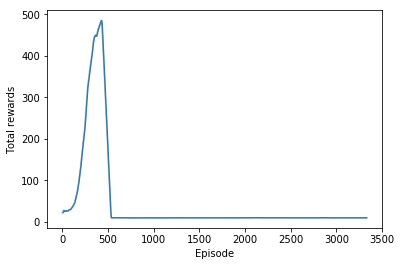

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

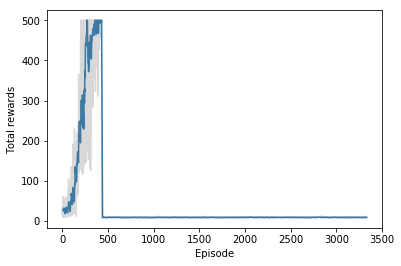

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

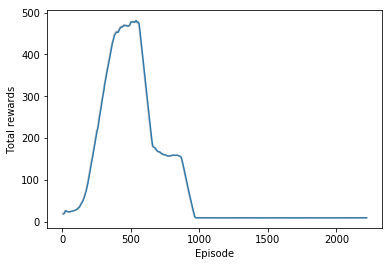

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

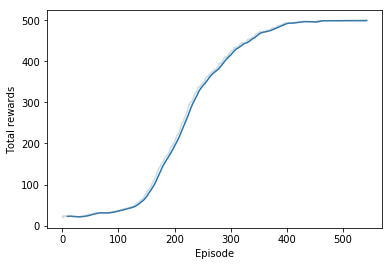

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

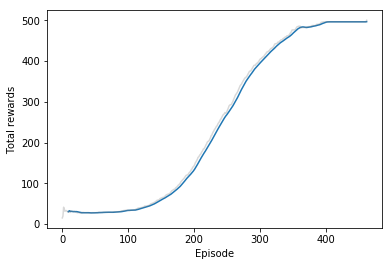

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

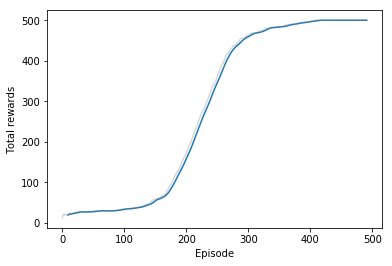

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

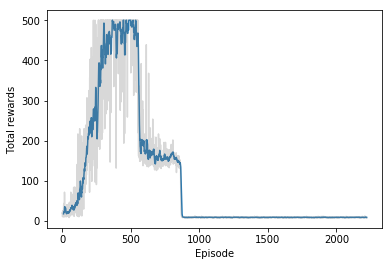

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

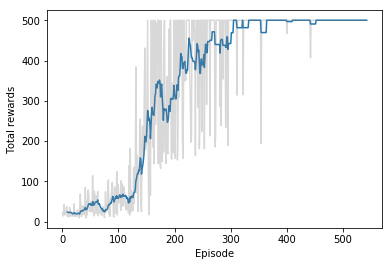

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

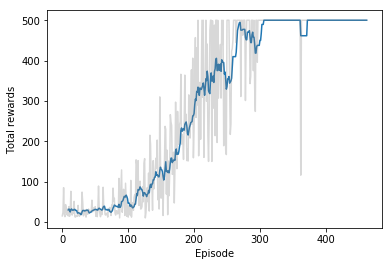

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

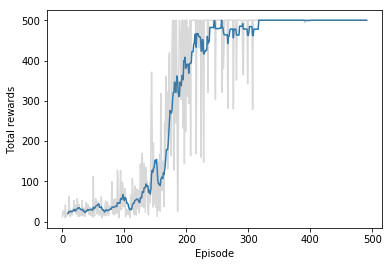

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.